In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

%matplotlib notebook

In [227]:
df = pd.read_csv('../data/preprocessed/details_home_for_sale_dataset_2019-07-14.csv')


In [228]:
df_obj = df.select_dtypes(include='object').fillna('').apply(lambda x: x.apply(lambda y: unidecode(y.lower())))
df_num = df.select_dtypes(exclude='object')
df_raw = pd.concat([df_num, df_obj], axis=1)

In [229]:
df_raw

,Unnamed: 0,acepta_permuta,altura_permitida,ambientes,ambientes_extra,ano_de_construccion,aptos_por_piso,banos,banos_extra,cantidad_de_pisos,...,disposicion,estado,extra,kind,referencia,sobre,tipo_propiedad,title,uri,zona
0,0,NaN,NaN,NaN,False,NaN,NaN,3.0,True,NaN,...,al frente,reciclada,"patio,living comedor,garaje",venta,584be,otros,casas,prox embajada eeuu padron 291 m2 con 10m de ft...,https://www.infocasas.com.uy/prx-embajada-eeuu...,palermo
1,1,NaN,NaN,NaN,False,1999.0,NaN,1.0,False,NaN,...,,excelente estado,"se aceptan mascotas,porton electrico,alarma",venta,137c1,,casas,"guana y blanes, precioso, 1 er piso por escale...",https://www.infocasas.com.uy/guana-y-blanes-pr...,parque rodo
2,2,NaN,NaN,NaN,False,2020.0,NaN,1.0,False,NaN,...,al frente,en construccion,terraza,venta,19ff5,,apartamentos,"gran penthouse, amplio, prox a f. derecho, ilu...",https://www.infocasas.com.uy/gran-penthouse-am...,cordon
3,3,NaN,NaN,6.0,True,NaN,NaN,3.0,True,NaN,...,,buen estado,,venta,48b96,,oficinas,importante edificio en ciudad vieja,https://www.infocasas.com.uy/importante-edific...,ciudad vieja
4,4,NaN,NaN,NaN,False,2015.0,NaN,1.0,False,10.0,...,al frente,a estrenar,"terraza,placard en dormitorio,placard en cocin...",venta,4c4e8,otros,apartamentos,apartamento a estrenar proximo a legrand!!,https://www.infocasas.com.uy/apartamento-a-est...,malvin
5,5,NaN,NaN,NaN,False,NaN,NaN,1.0,False,NaN,...,,reciclada,,venta,3fe9e,,casas,casa en venta monoambiente,https://www.infocasas.com.uy/casa-en-venta-mon...,union
6,6,NaN,NaN,4.0,False,1980.0,NaN,2.0,False,3.0,...,al frente,a reciclar,rejas,venta,660ac,otros,locales comerciales,venta local comercial ciudad vieja,https://www.infocasas.com.uy/venta-local-comer...,ciudad vieja
7,7,NaN,NaN,NaN,False,2020.0,NaN,1.0,False,3.0,...,interior,a estrenar,"terraza lavadero,terraza,placard en dormitorio...",venta,77197,,apartamentos,lanzamiento! vilaverdi plaza! 1 dormitorio y t...,https://www.infocasas.com.uy/lanzamiento-vilav...,malvin
8,8,NaN,NaN,2.0,False,NaN,NaN,1.0,False,NaN,...,,,,venta,eac1c,,negocio especial,"venta salon con juegos. pocitos, gabriel pereira",https://www.infocasas.com.uy/venta-saln-con-ju...,pocitos
9,9,NaN,NaN,NaN,False,NaN,NaN,NaN,False,NaN,...,,,"placard en dormitorio,placard en cocina,balcon",,,,,apartamento en venta 2 dormitorios,https://www.infocasas.com.uy/unidades/venta/18...,


In [230]:
df_raw['tipo_propiedad'].unique()

array(['casas', 'apartamentos', 'oficinas', 'locales comerciales',
       'negocio especial', '', 'terrenos', 'garaje o cocheras',
       'local industrial o galpon', 'edificios', 'otros',
       'chacras o campos', 'hoteles'], dtype=object)

In [231]:
mask = ((df_raw['oficina'] != 1) 
        & (df_raw['penthouse'] != 1) 
        & df_raw['tipo_propiedad'].isin(['apartamentos', 'casas'])
       )
df_raw = df_raw[mask]

In [232]:
columns = ['banos', 'disposicion', 'dormitorios',
           'estado', 'garajes', 'gastos_comunes',
           'm2_de_la_terraza', 'm2_del_terreno', 'm2_edificados',
           'price', 'tipo_propiedad', 'vivienda_social', 'zona']

In [233]:
df_selected = df_raw[columns].reset_index(drop=True)
fill_zero_col = ['m2_de_la_terraza', 'vivienda_social', 'gastos_comunes', 'garajes']
df_selected.loc[:, fill_zero_col] = df_selected.loc[:, fill_zero_col].fillna(0)
mask_m2_terreno = df_selected['m2_del_terreno'].isna()
df_selected.loc[mask_m2_terreno, 'm2_del_terreno'] = df_selected.loc[mask_m2_terreno, 'm2_edificados']
(
    df_selected
    .isna()
    .sum()
)

banos                74
disposicion           0
dormitorios          32
estado                0
garajes               0
gastos_comunes        0
m2_de_la_terraza      0
m2_del_terreno      833
m2_edificados       937
price                64
tipo_propiedad        0
vivienda_social       0
zona                  0
dtype: int64

In [234]:
df_selected.dropna(inplace=True)

In [151]:
df_num_selected = df_selected.select_dtypes(exclude='object')
df_obj_selected = df_selected.select_dtypes(include='object')

In [235]:
df_obj_selected.sample(5)

,disposicion,estado,tipo_propiedad,zona
993,al frente,excelente estado,casas,parque batlle
4516,al frente,excelente estado,casas,la blanqueada
678,,buen estado,casas,nuevo paris
2682,,buen estado,casas,union
3845,,reciclada,casas,carrasco - barrios con seguridad


In [236]:
zone_codes = pd.get_dummies(df_obj_selected['zona'])
property_type = pd.get_dummies(df_obj_selected['tipo_propiedad'])
property_state = pd.get_dummies(df_obj_selected['estado'])

In [237]:
zone_codes.columns = ['ZN_{}'.format(k.replace(' ', '_')) for k in zone_codes.columns]
property_state.columns = ['ST_{}'.format(k.replace(' ', '_')) for k in property_state.columns]


In [238]:
features_selected = pd.concat([df_num_selected, zone_codes, property_type, property_state], axis=1)


In [239]:
price =  features_selected['price']
features = features_selected.drop(columns=['price'])



In [240]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

scaler = MinMaxScaler()

In [241]:
train_features, test_features = train_test_split(features, test_size=0.2, random_state=14)
train_price, test_price = train_test_split(price, test_size=0.2, random_state=14)

pca = PCA(n_components=3,)
arr = pca.fit_transform(scaler.fit_transform(train_features))

In [242]:
pca.explained_variance_ratio_

array([0.19985261, 0.11876176, 0.0638695 ])

<IPython.core.display.Javascript object>


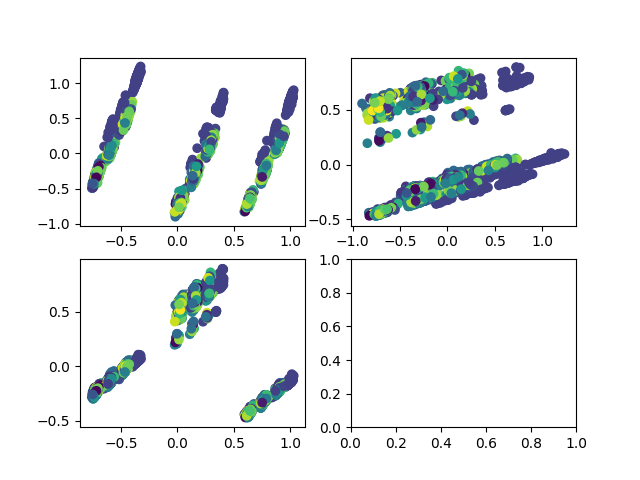

In [243]:
color = df_obj_selected.loc[train_features.index, 'zona'].astype('category').cat.codes
f, ax = plt.subplots(2,2)
ax[0, 0].scatter(arr[:,0], arr[:,1], c=color)
ax[0, 1].scatter(arr[:,1], arr[:,2], c=color)
ax[1, 0].scatter(arr[:,0], arr[:,2], c=color)

In [244]:
lda = LinearDiscriminantAnalysis(n_components=3).fit_transform(df_num_selected.drop(columns=['price']),
                                                              df_num_selected['price'])

<IPython.core.display.Javascript object>


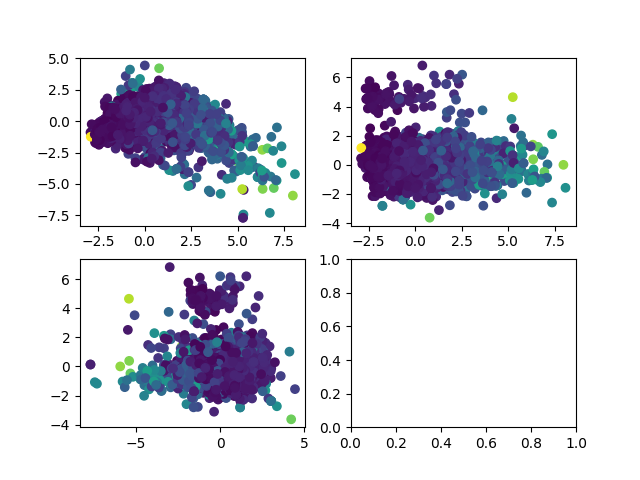

In [246]:
f, ax = plt.subplots(2, 2)
ax[0, 0].scatter(lda[:, 0], lda[:, 1], c=df_num_selected['price'])
ax[0, 1].scatter(lda[:, 0], lda[:, 2], c=df_num_selected['price'])
ax[1, 0].scatter(lda[:, 1], lda[:, 2], c=df_num_selected['price'])


In [247]:
def plot_predict_result(test_price, predict_price):
    f, ax = plt.subplots(2)
    ax[0].scatter(test_price, predict_price)
    ax[0].plot([0, 1600000], [0, 1600000], c='r')
    ax[1].hist(test_price - predict_price, bins=100)

# Linear Model

In [248]:
model = LinearRegression(fit_intercept=True)
model.fit(train_features, train_price)
model.coef_, model.intercept_, model.rank_

(array([ 1.91292699e+04, -2.13919790e+03,  2.41641254e+04,  2.70478553e+00,
         1.61999517e+01, -7.33554588e+01,  1.41849539e+03, -8.51123552e+03,
         1.88456721e+04, -8.36787897e+04, -4.31972995e+04, -1.18478167e+05,
        -8.05589229e+03, -1.39292353e+04,  9.77788771e+03, -1.26291508e+05,
         8.75940079e+04, -1.14500657e+05, -6.41010607e+04, -3.79605012e+02,
        -4.05512360e+04,  3.85576679e+04, -7.65312530e+04, -6.47892385e+04,
         2.64118123e+05,  3.67458064e+05,  1.38687339e+05,  1.10712761e+05,
         2.07797162e+05,  7.15954229e-09, -9.76247402e+04, -6.55090720e+04,
        -1.06164593e+05, -7.35498282e+04, -6.34422051e+04, -2.54388222e+03,
        -7.91443268e+03, -3.46505874e+03, -5.30752397e+04, -4.01248239e+04,
         4.23712033e+05, -4.38738072e+04, -2.49220441e+04, -5.85772538e+04,
        -1.15460431e+04, -7.61999348e+04, -1.99409106e+04, -2.65932172e+04,
        -6.82087412e+04, -2.19512980e+04, -9.29677979e+04, -5.80913904e+04,
         5.1

In [249]:
predict_price = model.predict(test_features)

<IPython.core.display.Javascript object>


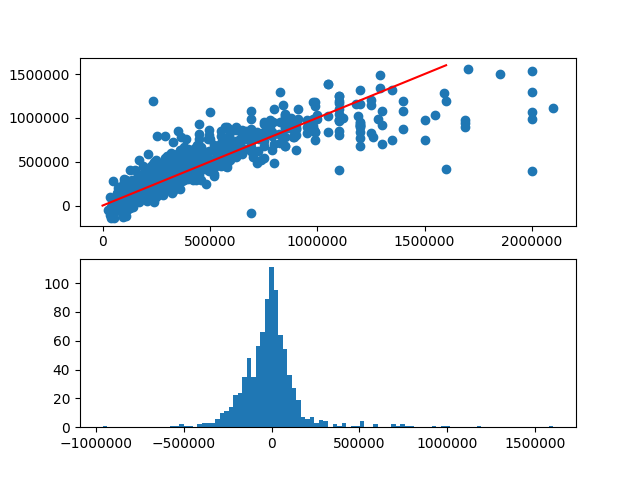

In [250]:
plot_predict_result(test_price, predict_price)

# Regression Tree

In [251]:
cls_tree = DecisionTreeRegressor()
cls_tree.fit(train_features, train_price)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [252]:
predic_price_tree = cls_tree.predict(test_features)

<IPython.core.display.Javascript object>


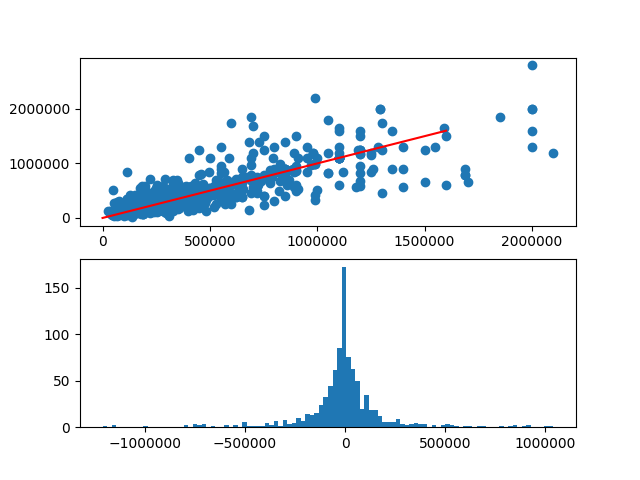

In [253]:
plot_predict_result(test_price, predic_price_tree)

<IPython.core.display.Javascript object>


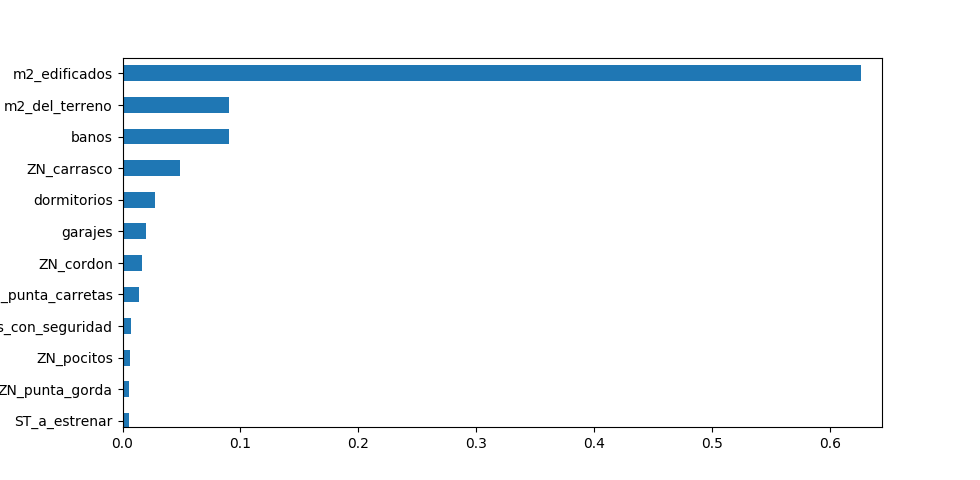

In [254]:
f, ax = plt.subplots()
(pd
 .Series(cls_tree.feature_importances_, index=train_features.columns)
 .sort_values()
 .plot(ax=ax, kind='barh')
)